# ДЗ2

- Студент: Алексей Ярошенко
- Email на портале: aleksey.yaroshenko@gmail.com
- https://docs.google.com/document/d/1E6Mvo_0CBZelxhQyHM37R3DKdgVWDEeC56SZ2A9DNIc/edit

## 1. Загрузка и подготовка данных

Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).

In [1734]:
from datetime import timedelta

import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import multivariate_normal
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [1735]:
figsize = (16, 8)

In [1736]:
df_all = pd.read_csv(
    'https://covid.ourworldindata.org/data/owid-covid-data.csv', 
    parse_dates=['date'],
    usecols=lambda col: col not in {'tests_units'}
)

df_all['new_cases'].replace(0, 1, inplace=True)

df_ru = df_all[
    (df_all['location'] == 'Russia') & 
    (df_all['date'] >= '2020-03-03')
].fillna(0)

TRAIN_SIZE = 60

df_train, df_test = df_ru[:TRAIN_SIZE], df_ru[TRAIN_SIZE:]
df_train.head()

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,...,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_100k
13614,RUS,Russia,2020-03-03,3,1,0,0,0.021,0.007,0.0,...,14.178,9.393,24765.954,0.1,431.297,6.18,23.4,58.3,0.0,8.05
13615,RUS,Russia,2020-03-04,4,1,0,0,0.027,0.007,0.0,...,14.178,9.393,24765.954,0.1,431.297,6.18,23.4,58.3,0.0,8.05
13616,RUS,Russia,2020-03-05,4,1,0,0,0.027,0.000,0.0,...,14.178,9.393,24765.954,0.1,431.297,6.18,23.4,58.3,0.0,8.05
13617,RUS,Russia,2020-03-06,4,1,0,0,0.027,0.000,0.0,...,14.178,9.393,24765.954,0.1,431.297,6.18,23.4,58.3,0.0,8.05
13618,RUS,Russia,2020-03-07,10,6,0,0,0.069,0.041,0.0,...,14.178,9.393,24765.954,0.1,431.297,6.18,23.4,58.3,0.0,8.05


## 2. Визуализация и первая модель

Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.

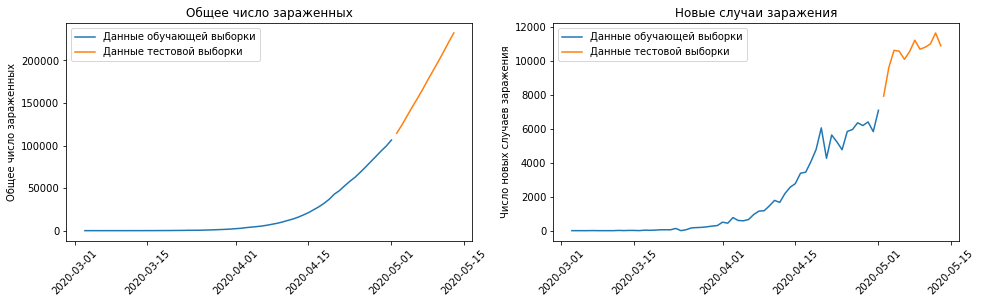

In [1737]:
fig, axis = plt.subplots(1, 2, figsize=(16, 4))

axis[0].plot(df_train['date'], df_train['total_cases'], label='Данные обучающей выборки')
axis[0].plot(df_test['date'], df_test['total_cases'], label='Данные тестовой выборки')
axis[0].set_ylabel('Общее число зараженных')
axis[0].set_title('Общее число зараженных')
axis[0].legend()

axis[1].plot(df_train['date'], df_train['new_cases'], label='Данные обучающей выборки')
axis[1].plot(df_test['date'], df_test['new_cases'], label='Данные тестовой выборки')
axis[1].set_ylabel('Число новых случаев заражения')
axis[1].set_title('Новые случаи заражения')
axis[1].legend()

for ax in axis:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

### a) y ~ exp(линейная функция от x)

Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.

In [1738]:
x_train = np.arange(0, TRAIN_SIZE, 1)
x_test = np.arange(TRAIN_SIZE, TRAIN_SIZE + df_test.shape[0], 1)

y_train_total = df_train['total_cases'].values
y_test_total = df_test['total_cases'].values

y_train_new = df_train['new_cases'].values
y_test_new = df_test['new_cases'].values

Чтобы получить параметры апостериорного распределения, сделаем подходящий класс с интерфейсом как sklearn, откуда можно эти параметры ($\mu_n, cov_n$) легко достать. А заодно и семплировать предсказания

In [1739]:
class MyBayesianRegression():
    def __init__(self, init_mu, init_sigma):
        self.init_mu = init_mu
        self.init_sigma = init_sigma
    
    def fit(self, X, y):
        X = np.hstack((np.ones((len(X), 1)), X))
        
        # Оцениваем шум в данных
        W = np.linalg.inv(X.T @ X) @ X.T @ y
        y_pred = X @ W
        noise_var = (y - y_pred).var()
        alpha = 1 / noise_var
            
        # Байесовский апдейт
        self.sigma_ = np.linalg.inv(np.linalg.inv(self.init_sigma) + alpha * X.T @ X)
        self.mu_ = self.sigma_ @ (np.linalg.inv(self.init_sigma) @ self.init_mu + alpha * X.T @ y)
        
    def predict(self, X):
        X = np.hstack((np.ones((len(X), 1)), X))
        return X @ self.mu_
    
    def predict_samples(self, X, n_samples=200):
        X = np.hstack((np.ones((len(X), 1)), X))
        Ws = np.random.multivariate_normal(self.mu_, self.sigma_, n_samples)
        results = []
        for W in Ws:
            y = X @ W
            results.append(y)
            
        return np.array(results)

**Для целевой переменной total_cases**

Для целевой переменной new_cases не вижу смысла это делать, т.к. число новых случаев когда-то будет падать, а экспонента - нет. И к тому же, ид одного всегда можно получить другое.

Просто обучим линейную регрессию для логарифма таргета. Потом возьмем экспоненту от предсказаний.

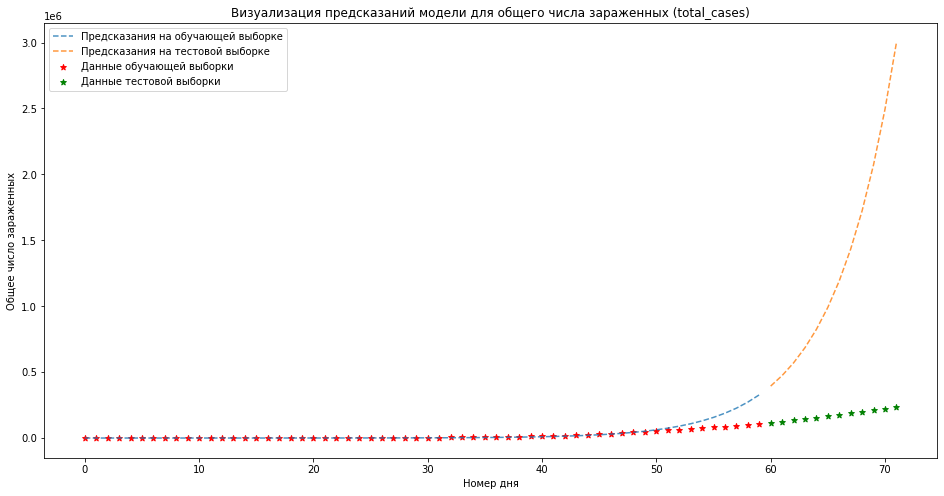

In [1740]:
model_exp = MyBayesianRegression(
    init_mu=np.array([0, 0]),
    init_sigma=20*np.array([[1, 0], [0, 1]]),
)

lr_for_check = LinearRegression() # Для проверки, все ли ок с нашей кастомной регрессией

model_exp.fit(x_train.reshape(-1, 1), np.log(y_train_total))
lr_for_check.fit(x_train.reshape(-1, 1), np.log(y_train_total))

# Т.к. априорное распределение у нас на результат почти не влияет
# проверим модель обычной линейной регрессией. На всякий случай
assert (model_exp.mu_[0] - lr_for_check.intercept_) < 0.001 # Проверяем, совпадает ли смещение
assert (model_exp.mu_[1] - lr_for_check.coef_[0]) < 0.001 # Проверяем, совпадает ли наклон

y_train_total_pred = np.exp(model_exp.predict(x_train.reshape(-1, 1)))
y_test_total_pred = np.exp(model_exp.predict(x_test.reshape(-1, 1)))

plt.figure(figsize=figsize)
plt.plot(x_train, y_train_total_pred, linestyle='--', alpha=0.8, label='Предсказания на обучающей выборке')
plt.scatter(x_train, y_train_total, label='Данные обучающей выборки', marker='*', color='red')
plt.plot(x_test, y_test_total_pred, linestyle='--', alpha=0.8, label='Предсказания на тестовой выборке')
plt.scatter(x_test, y_test_total, label='Данные тестовой выборки', marker='*', color='green')
plt.xlabel('Номер дня')
plt.ylabel('Общее число зараженных')
plt.title('Визуализация предсказаний модели для общего числа зараженных (total_cases)')
plt.legend();

**Факультативно обучим кривую с MSE**

Мы оптимизировали MSLE, а не MSE, т.к. логарифмируем таргет. Попробуем оптимизировать MSE, а не MSLE. Просто ради интереса.

Обучим кривую с помощью метода наименьших квадратов. Посмотрим, как отличаются предсказания


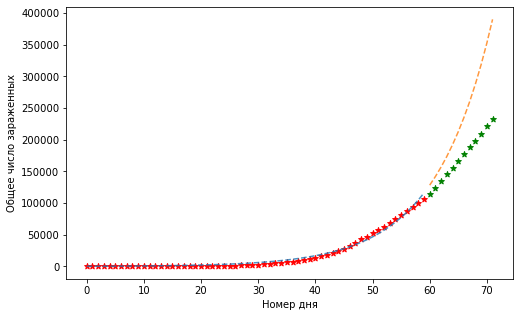

In [1741]:
def curve(x, w, b):
    return np.exp(w*x + b)

(w, b), _ = curve_fit(curve, xdata=x_train, ydata=y_train_total)

plt.figure(figsize=(8, 5))
plt.plot(x_train, curve(x_train, w, b), linestyle='--', alpha=0.8, label='Предсказания на обучающей выборке')
plt.scatter(x_train, y_train_total, label='Данные обучающей выборки', marker='*', color='red')
plt.plot(x_test, curve(x_test, w, b), linestyle='--', alpha=0.8, label='Предсказания на тестовой выборке')
plt.scatter(x_test, y_test_total, label='Данные тестовой выборки', marker='*', color='green')
plt.xlabel('Номер дня')
plt.ylabel('Общее число зараженных')
plt.show()

Выглядит как-то немного более правдоподобно. Ну да ладно.

### b) Апостериорное распределение параметров модели

Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

Параметры модели: [1.81353477 0.18450938]


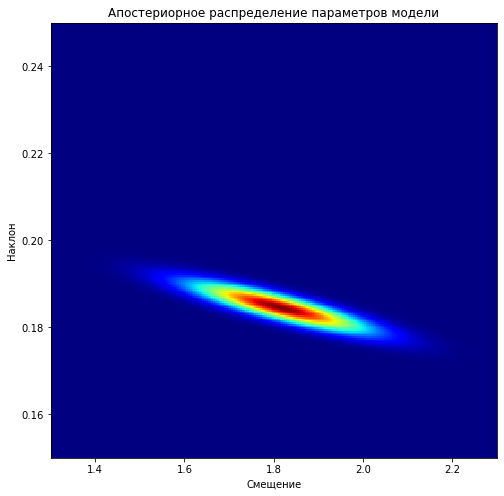

In [1742]:
N = 250

plot_lims = (
    (1.3, 2.3),
    (0.15, 0.25)
)

X = np.linspace(*plot_lims[0], N)
Y = np.linspace(*plot_lims[1], N)
X, Y = np.meshgrid(X, Y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

print(f'Параметры модели: {model_exp.mu_}') 

Z = multivariate_normal.pdf(pos, mean=model_exp.mu_, cov=model_exp.sigma_)

plt.figure(figsize=(8, 8))
plt.xlim(plot_lims[0])
plt.ylim(plot_lims[1])
plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
plt.title('Апостериорное распределение параметров модели')
plt.xlabel('Смещение')
plt.ylabel('Наклон')
plt.show()

### c) Посэмплируйте много разных экспонент, постройте графики. 

Посэмплируйте много разных экспонент, постройте графики. 
- Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? 
- Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).


In [1743]:
date_start = pd.to_datetime('2020-03-03')
date_may = pd.to_datetime('2020-05-01')
date_june = pd.to_datetime('2020-06-01')
date_sept = pd.to_datetime('2020-09-01')

x_may = np.array([[(date_may - date_start).days]])
x_june = np.array([[(date_june - date_start).days]])
x_sept = np.array([[(date_sept - date_start).days]])

y_may_total = int(np.exp(model_exp.predict(x_may)))
y_june_total = int(np.exp(model_exp.predict(x_june)))
y_sept_total = int(np.exp(model_exp.predict(x_sept)))

print(f'К 1 мая модель предсказывает всего {y_may_total} случаев')
print(f'К 1 июня модель предсказывает всего {y_june_total} случаев')
print(f'К 1 сентября модель предсказывает всего {y_sept_total} случаев')

К 1 мая модель предсказывает всего 327613 случаев
К 1 июня модель предсказывает всего 99869938 случаев
К 1 сентября модель предсказывает всего 2352470784906319 случаев


Дичь, в общем.

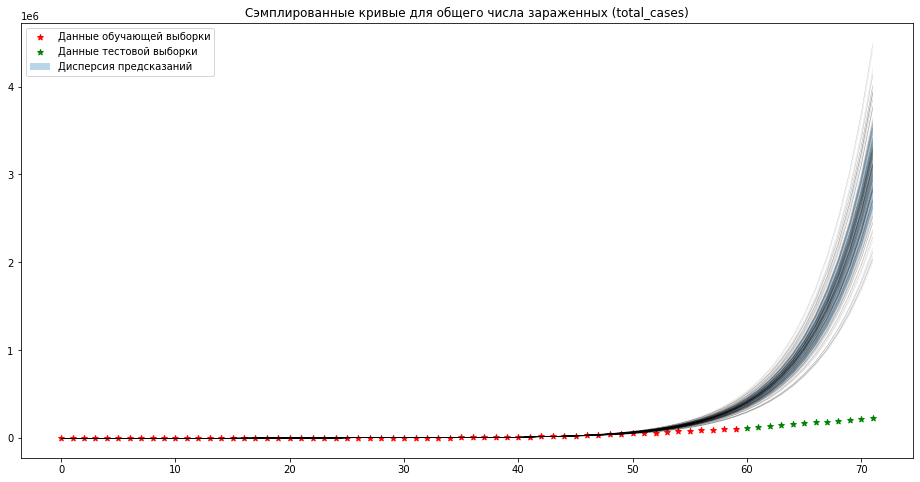

In [1744]:
plt.figure(figsize=figsize)
x_sample = np.hstack((x_train, x_test))
y_samples = np.exp(model_exp.predict_samples(x_sample.reshape(-1, 1)))

for y_sample in y_samples:
    plt.plot(x_sample, y_sample, 'k-', lw=0.05)
    
lower_bound = np.mean(y_samples, axis=0) - np.std(y_samples, axis=0) 
upper_bound = np.mean(y_samples, axis=0) + np.std(y_samples, axis=0)
    
plt.scatter(x_train, y_train_total, label='Данные обучающей выборки', marker='*', color='red')
plt.scatter(x_test, y_test_total, label='Данные тестовой выборки', marker='*', color='green')
plt.fill_between(x_sample, lower_bound, upper_bound, alpha=0.3, label='Дисперсия предсказаний')


plt.title('Сэмплированные кривые для общего числа зараженных (total_cases)')
plt.legend();
plt.show()

Такое впечатление, что моделировать экспонентой - далеко не лучшее решение

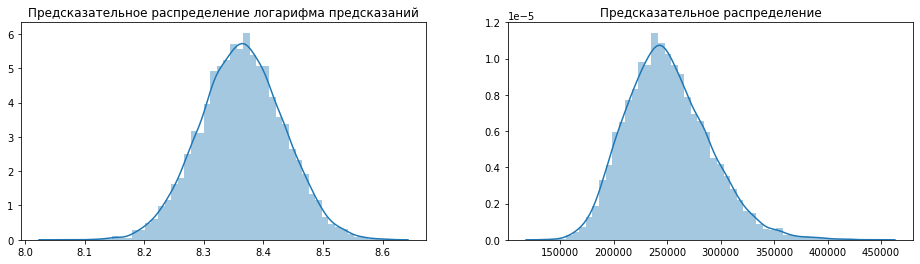

In [1745]:
y_samples_log = model_exp.predict_samples(x_sample.reshape(-1, 1), n_samples=10000)
y_samples = np.exp(y_samples_log)

fig, axis = plt.subplots(1, 2, figsize=(16, 4))

sns.distplot(y_samples_log.mean(axis=1), ax=axis[0])
axis[0].set_title('Предсказательное распределение логарифма предсказаний')

sns.distplot(y_samples.mean(axis=1), ax=axis[1])
axis[1].set_title('Предсказательное распределение');

## 3. Моделирование сигмоидой

Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана.

Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t.

### a) Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.

Переменная total_cases - это, аккумулированная (можно условно сказать, проинтегрированная) переменная new_cases. Зная одну, мы можем легко узнать и другую. 

Поэтому, если мы моделируем total_cases функцией нормального распределения (проинтегрированная плотность распределения), то мы так же можем смоделировать переменную new_cases плотностью нормального распределения с теми же параметрами. И потом просто аккумулировать предсказания по new_cases, чтобы получить total_cases.

Для того, чтобы обучиться под плотность нормального распределения (экспоненту квадратичной функции) линейной регрессией, обучим полином 2 степени от логарифма таргета.

$y = e^{ax^2 + bx + c}$

$\ln{y} =ax^2 + bx + c$

Если бы нам в задаче понадобились $\mu$ и $\sigma$, то мы могли бы перейти от коэффициентов линейной регрессии к ним с помощью алгоритма Каруана (https://arxiv.org/pdf/1907.07241.pdf). Знать конкретные параметры обучаемого распределения нам в задаче не нужно, поэтому этот шаг можем опустить. Ради интереса посчитаем среднее значение $\mu=\frac{-b}{2c}$, его можно интерпретировать как пик пандемии.

### b) Обучение модели 

Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.

Параметры модели: [-0.7762618   0.28529506 -0.00200276]

Пик пандемии в РФ, судя по модели, будет примерно 2020-05-13


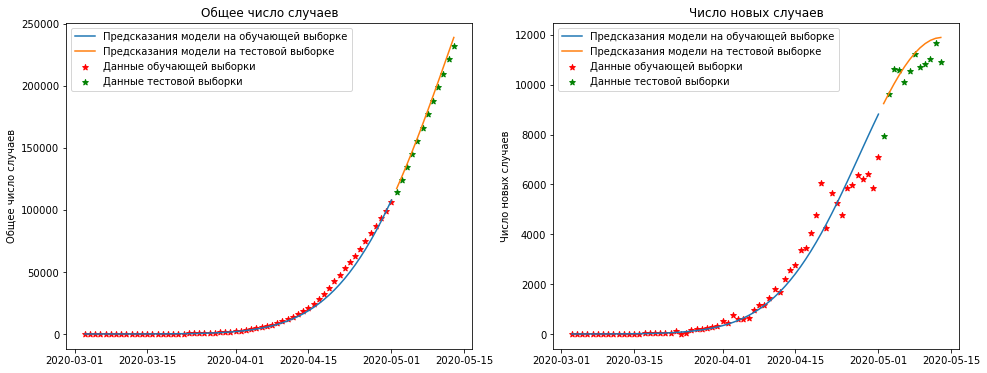

In [1746]:
X_train = np.array([x_train, (x_train) ** 2]).T
X_test = np.array([x_test, (x_test) ** 2]).T

model_sigmoid = MyBayesianRegression(
    init_mu=np.array([0, 0, 0]),
    init_sigma=10*np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]),
)

model_sigmoid.fit(X_train, np.log(y_train_new))
print(f'Параметры модели: {model_sigmoid.mu_}\n')

# Воспользуемся алгоритмом Каруана, посчитаем среднее гауссианы
c, b, a = model_sigmoid.mu_
mu_dist = -b/(2*a)
peak = pd.to_datetime('2020-03-03') + timedelta(days=np.round(mu_dist))
print(f'Пик пандемии в РФ, судя по модели, будет примерно {peak.strftime("%Y-%m-%d")}')


y_train_new_sigmoid = np.exp(model_sigmoid.predict(X_train))
y_test_new_sigmoid = np.exp(model_sigmoid.predict(X_test))

y_train_total_sigmoid = y_train_new_sigmoid.cumsum()
y_test_total_sigmoid = y_train_total_sigmoid.max() + y_test_new_sigmoid.cumsum()

train_dates = [pd.to_datetime('2020-03-03') + timedelta(days=i) for i in range(len(x_train))]
test_dates = [pd.to_datetime('2020-03-03') + timedelta(days=(i + len(x_train))) for i in range(len(x_test))]

fig, axis = plt.subplots(1, 2, figsize=(16, 6))

axis[0].scatter(train_dates, y_train_total, label='Данные обучающей выборки', marker='*', color='red')
axis[0].scatter(test_dates, y_test_total, label='Данные тестовой выборки', marker='*', color='green')
axis[0].plot(train_dates, y_train_total_sigmoid, label='Предсказания модели на обучающей выборке')
axis[0].plot(test_dates, y_test_total_sigmoid, label='Предсказания модели на тестовой выборке')
axis[0].set_ylabel('Общее число случаев')
axis[0].set_title('Общее число случаев')
axis[0].legend()


axis[1].scatter(train_dates, y_train_new, label='Данные обучающей выборки', marker='*', color='red')
axis[1].scatter(test_dates, y_test_new, label='Данные тестовой выборки', marker='*', color='green')
axis[1].plot(train_dates, y_train_new_sigmoid, label='Предсказания модели на обучающей выборке')
axis[1].plot(test_dates, y_test_new_sigmoid, label='Предсказания модели на тестовой выборке')
axis[1].set_ylabel('Число новых случаев')
axis[1].set_title('Число новых случаев')
axis[1].legend()

plt.show();

**Построим прогноз на 5 месяцев вперед**

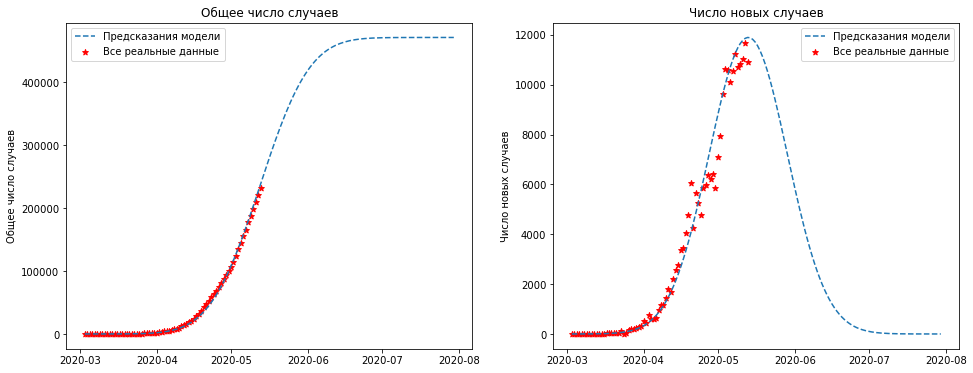

In [1747]:
FORECAST_DAYS = 150
X_future = np.array([np.arange(FORECAST_DAYS), np.arange(FORECAST_DAYS) ** 2]).T
y_future_new = np.exp(model_sigmoid.predict(X_future))
y_future_total = y_future_new.cumsum()

future_dates = [pd.to_datetime('2020-03-03') + timedelta(days=i) for i in range(FORECAST_DAYS)]

fig, axis = plt.subplots(1, 2, figsize=(16, 6))

axis[0].plot(future_dates, y_future_total, label=f'Предсказания модели', linestyle='--')
axis[0].scatter(future_dates[:df_ru.shape[0]], df_ru['total_cases'], label=f'Все реальные данные', marker='*', color='red')
axis[0].set_ylabel('Общее число случаев')
axis[0].set_title('Общее число случаев')
axis[0].legend()


axis[1].plot(future_dates, y_future_new, label=f'Предсказания модели', linestyle='--')
axis[1].scatter(future_dates[:df_ru.shape[0]], df_ru['new_cases'], label=f'Все реальные данные', marker='*', color='red')
axis[1].set_ylabel('Число новых случаев')
axis[1].set_title('Число новых случаев')
axis[1].legend()

plt.show();

Судя по модели, в начале июля все будет хорошо. Но я бы не был столь уверен, т.к. в больших странах правый хвост гауссианы длинный и тяжелый (это я смотрел)

### c) Семплирование из апостериорного распределения

- Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. 
- Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

**Построим много сигмоид**

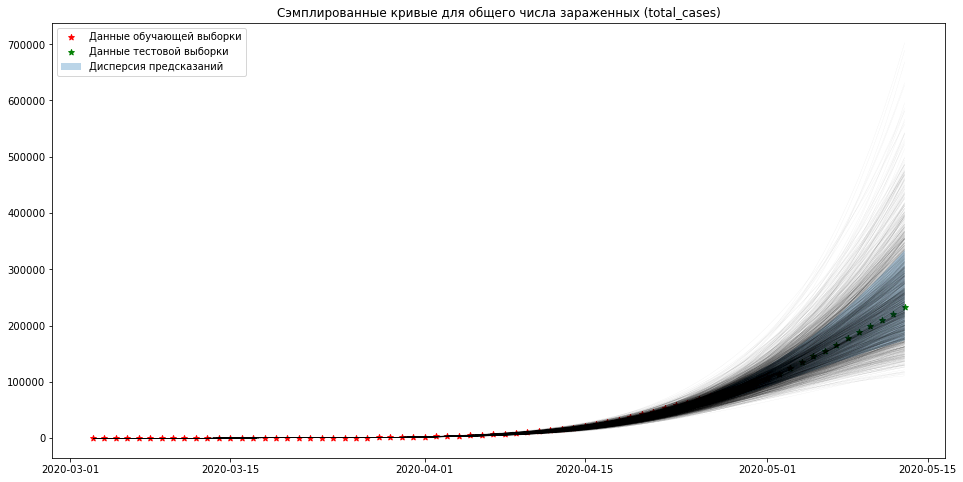

In [1748]:
plt.figure(figsize=figsize)
X_sample = np.vstack((X_train, X_test))
y_samples = np.exp(model_sigmoid.predict_samples(X_sample, n_samples=2000)).cumsum(axis=1)

for y_sample in y_samples:
    plt.plot(np.hstack((train_dates, test_dates)), y_sample, 'k-', lw=0.02)
    
lower_bound = np.mean(y_samples, axis=0) - np.std(y_samples, axis=0) 
upper_bound = np.mean(y_samples, axis=0) + np.std(y_samples, axis=0)
    
plt.scatter(train_dates, y_train_total, label='Данные обучающей выборки', marker='*', color='red')
plt.scatter(test_dates, y_test_total, label='Данные тестовой выборки', marker='*', color='green')
plt.fill_between(np.hstack((train_dates, test_dates)), lower_bound, upper_bound, alpha=0.3, label='Дисперсия предсказаний')

plt.title('Сэмплированные кривые для общего числа зараженных (total_cases)')
plt.legend();
plt.show()

Посемплируем из периода побольше

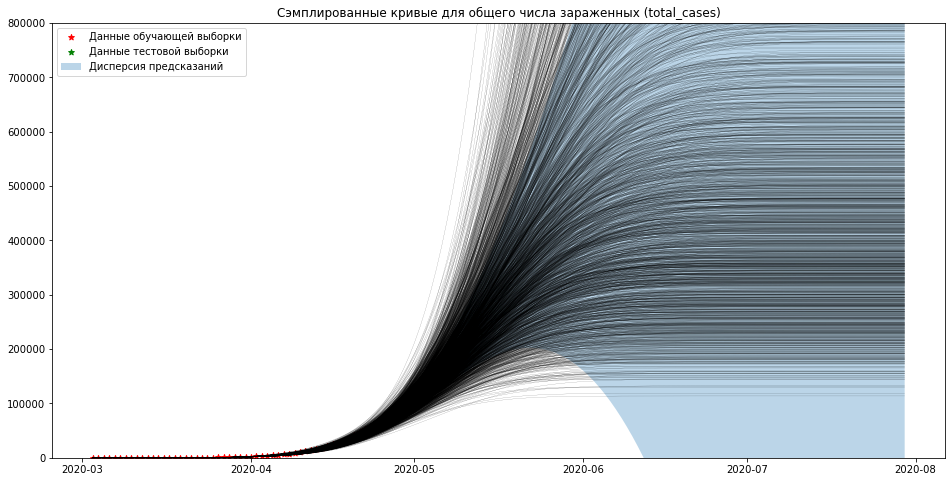

In [1749]:
plt.figure(figsize=figsize)
y_samples = np.exp(model_sigmoid.predict_samples(X_future, n_samples=2000)).cumsum(axis=1)

for y_sample in y_samples:
    plt.plot(future_dates, y_sample, 'k-', lw=0.1)
    
lower_bound = np.mean(y_samples, axis=0) - np.std(y_samples, axis=0) 
upper_bound = np.mean(y_samples, axis=0) + np.std(y_samples, axis=0)

    
plt.scatter(train_dates, y_train_total, label='Данные обучающей выборки', marker='*', color='red')
plt.scatter(test_dates, y_test_total, label='Данные тестовой выборки', marker='*', color='green')
plt.fill_between(future_dates, lower_bound, upper_bound, alpha=0.3, label='Дисперсия предсказаний')
plt.ylim((0, 800_000))
plt.title('Сэмплированные кривые для общего числа зараженных (total_cases)')
plt.legend();
plt.show()

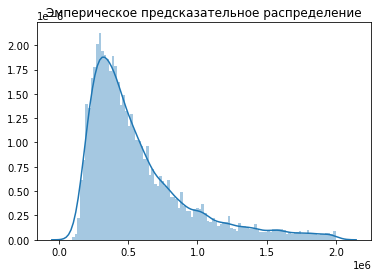

In [1751]:
y_samples = np.exp(model_sigmoid.predict_samples(X_future, n_samples=10000)).cumsum(axis=1)[:, -1]
sns.distplot(y_samples[y_samples < 2000000], bins=100)
plt.title('Эмперическое предсказательное распределение');

In [1718]:
print(f'Прогноз числа случаев в случае оптимистичного сценария (10-й процентиль). Случаев: {np.percentile(y_samples, 10):.0f}')
print(f'Прогноз числа случаев в случае пессимистичного сценария (90-й процентиль). Случаев: {np.percentile(y_samples, 90):.0f}')

Прогноз числа случаев в случае оптимистичного сценария (10-й процентиль). Случаев: 241203
Прогноз числа случаев в случае пессимистичного сценария (90-й процентиль). Случаев: 1373118


## 4. Анализ для других стран

Проведите такой же анализ для других стран (здесь придётся руками подобрать дни начала моделирования — коронавирус приходил в разные страны в разное время). Насколько разные параметры получаются? Можно ли разделить страны на кластеры (хотя бы чисто визуально) в зависимости от этих параметров?

Страна: Belarus, дата начала: 2020-03-18


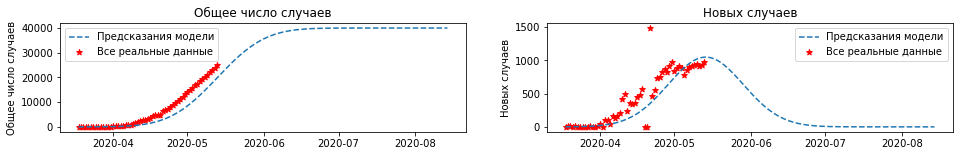

Страна: Russia, дата начала: 2020-03-03


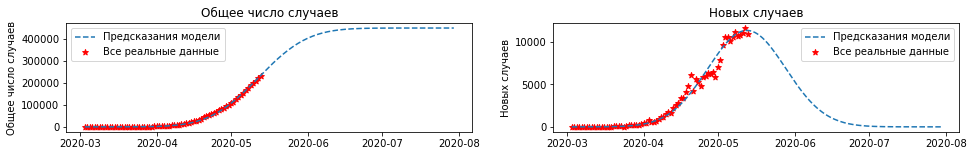

Страна: Spain, дата начала: 2020-02-24


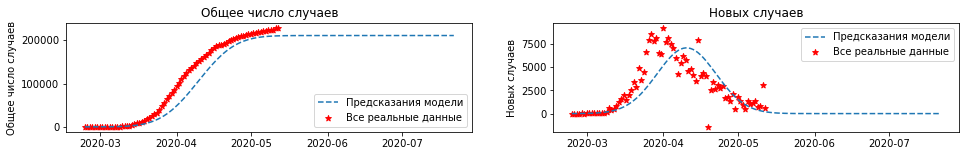

Страна: Ireland, дата начала: 2020-02-27


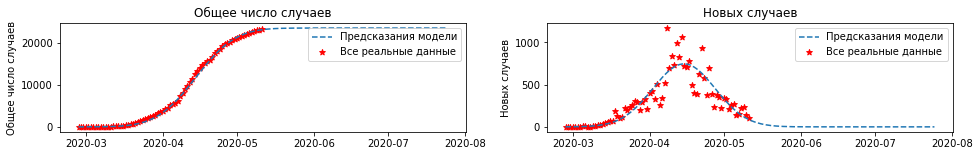

Страна: Germany, дата начала: 2020-02-23


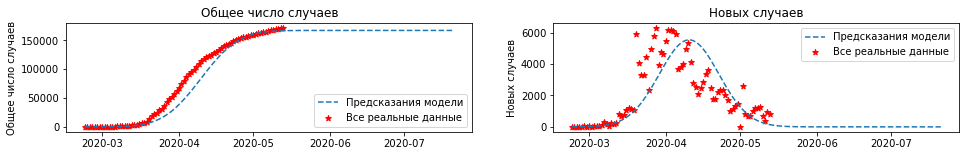

Страна: United States, дата начала: 2020-03-15


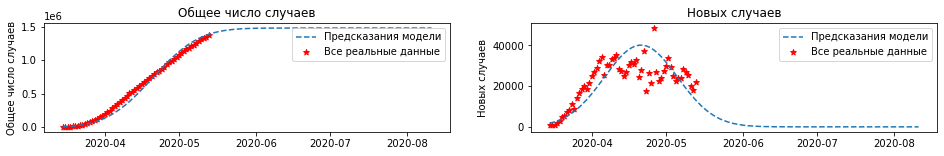

Страна: Poland, дата начала: 2020-03-07


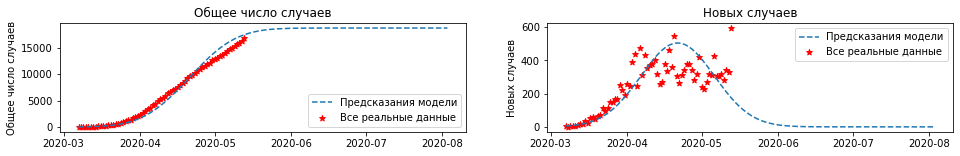

Страна: Brazil, дата начала: 2020-03-19


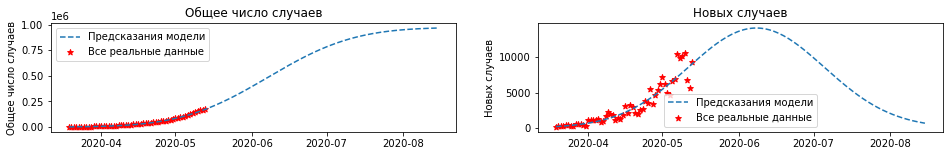

Страна: Canada, дата начала: 2020-02-20


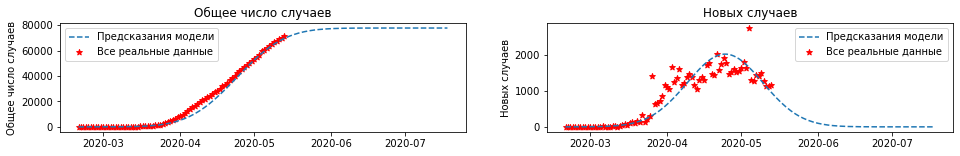

Страна: France, дата начала: 2020-02-26


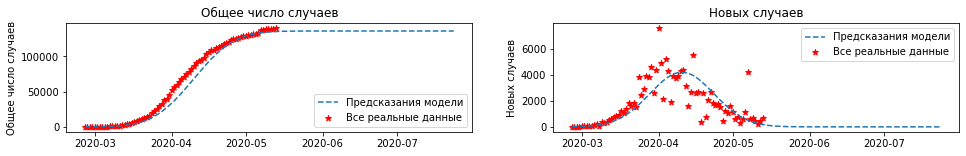

Страна: India, дата начала: 2020-03-23


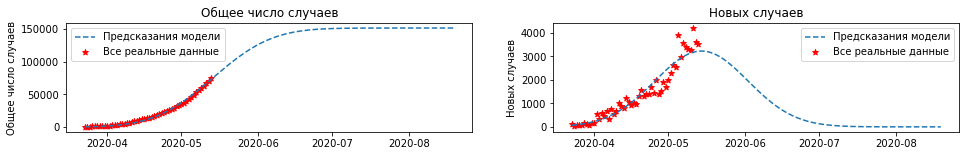

Страна: Sweden, дата начала: 2020-02-27


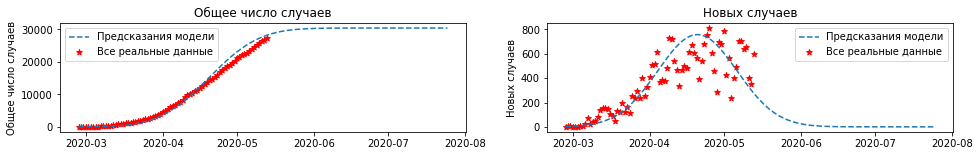

Страна: United Kingdom, дата начала: 2020-02-13


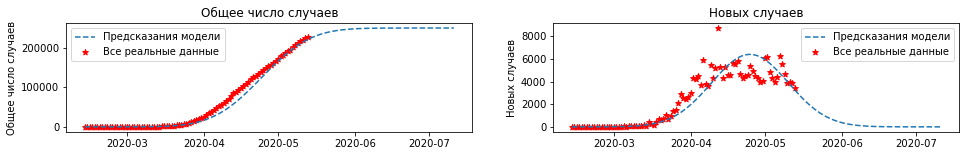

Страна: Philippines, дата начала: 2020-02-10


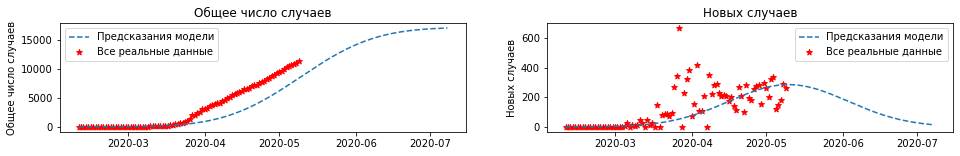

Страна: Greece, дата начала: 2020-02-18


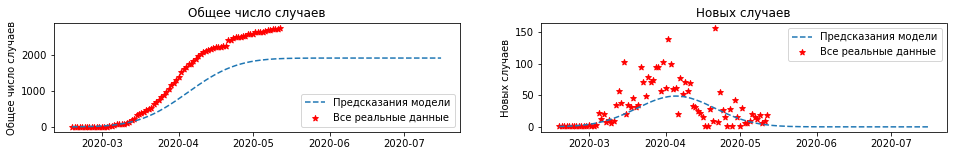

Страна: Mexico, дата начала: 2020-03-15


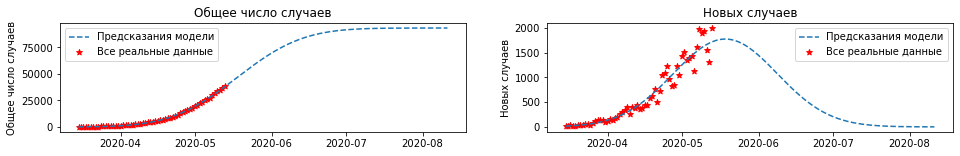

Страна: Italy, дата начала: 2020-02-02


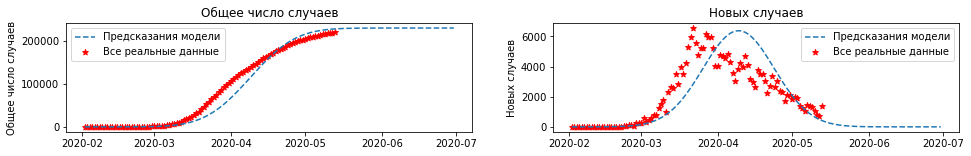

Страна: Portugal, дата начала: 2020-03-01


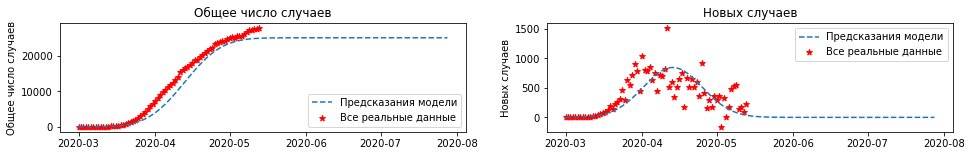

Страна: Estonia, дата начала: 2020-02-28


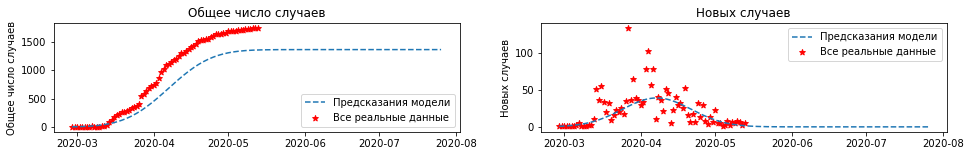

Страна: Denmark, дата начала: 2020-02-21


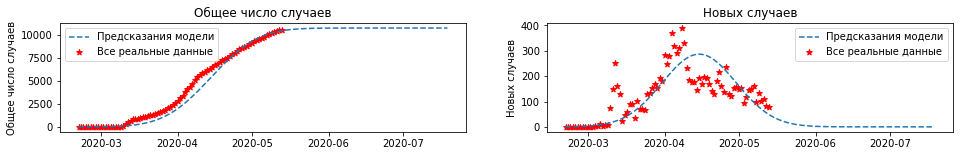

In [1758]:
TEST_LEN = 8
FORECAST_DAYS = 150
locations = {
    'Belarus': '2020-03-18',
    'Russia': '2020-03-03',
    'Spain': '2020-02-24',
    'Ireland': '2020-02-27',
    'Germany': '2020-02-23',
    'United States': '2020-03-15',
    'Poland': '2020-03-07',
    'Brazil': '2020-03-19',
    'Canada': '2020-02-20',
    'France': '2020-02-26',
    'India': '2020-03-23',
    'Sweden': '2020-02-27',
    'United Kingdom': '2020-02-13',
    'Philippines': '2020-02-10',
    'Greece': '2020-02-18',
    'Mexico': '2020-03-15',
    'Italy': '2020-02-02',
    'Portugal': '2020-03-01',
    'Estonia': '2020-02-28',
    'Denmark': '2020-02-21',
}

# location = 'Belarus'
# date = '2020-03-18'
parameters = []


for location, date in locations.items():

    df = df_all[(df_all['location'] == location) & (df_all['date'] >= date)]
    # df = df_all[(df_all['location'] == location) & (df_all['total_cases_per_million'] >= 0.4)]

    x_train = np.arange(df.shape[0] - TEST_LEN)
    x_test = np.arange(df.shape[0] - TEST_LEN, df.shape[0]) 

    X_train = np.array([x_train, x_train**2]).T
    X_test = np.array([x_test, x_test**2]).T
    X = np.vstack((X_train, X_test))

    X_future = np.array([np.arange(FORECAST_DAYS), np.arange(FORECAST_DAYS) ** 2]).T

    y_new = np.clip(df['new_cases'], 1, None)
    y_total = np.clip(df['total_cases'], 0, None)
    y_train_new = y_new[:-TEST_LEN]
    y_test_new = y_new[-TEST_LEN:]
    y_train_total = y_total[:-TEST_LEN]
    y_test_total = y_total[-TEST_LEN:]


    train_dates = [df['date'].min() + timedelta(days=i) for i in range(df.shape[0] - TEST_LEN)]
    test_dates = [train_dates[-1] + timedelta(days=i + 1) for i in range(TEST_LEN)]
    all_dates = train_dates + test_dates
    future_dates = [df['date'].min() + timedelta(days=i) for i in range(FORECAST_DAYS)]

    model = MyBayesianRegression(
        init_mu=np.array([0, 0, 0]),
        init_sigma=10*np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]),
    )

    # Будем героически учить модель сразу на всех данных
    model.fit(X, np.log(y_new))


    print(f'Страна: {location}, дата начала: {date}')

    parameters.append((location, model.mu_))

    y_future_new = np.exp(model.predict(X_future))
    y_future_total = y_future_new.cumsum()

    fig, axis = plt.subplots(1, 2, figsize=(16, 2))

    axis[0].plot(future_dates, y_future_total, label=f'Предсказания модели', linestyle='--')
    axis[0].scatter(future_dates[:df.shape[0]], df['total_cases'], label=f'Все реальные данные', marker='*', color='red')
    axis[0].set_ylabel('Общее число случаев')
    axis[0].set_title('Общее число случаев')
    axis[0].legend()

    axis[1].plot(future_dates, y_future_new, label=f'Предсказания модели', linestyle='--')
    axis[1].scatter(future_dates[:df.shape[0]], df['new_cases'], label=f'Все реальные данные', marker='*', color='red')
    axis[1].set_ylabel('Новых случаев')
    axis[1].set_title('Новых случаев')
    axis[1].legend();

    plt.show();

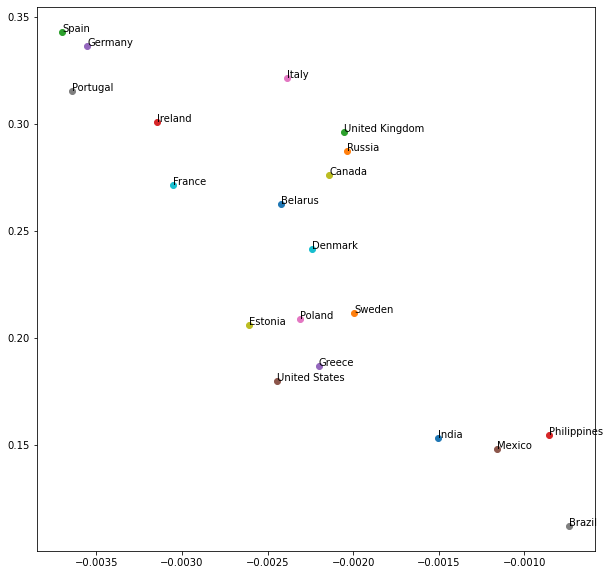

In [1755]:
fig, ax = plt.subplots(figsize=(10, 10))
for country, (_, b, a) in parameters:
    x, y = a, b
    ax.scatter(x, y)
    ax.annotate(country, (x, y))

### Наблюдение:

Положение на графике довольно близко совпадает с прогнозируемой продолжительностью эпидемии.  

- В нижнем правом углу графика - теплые страны с невысоким уровнем жизни. Там модель предсказывает, что все затянется. *Индия, Филлипины, Бразилия, Мексика...*
- В верхнем левом углу - европейские страны, где все как довольно резко началось, так и закончилось. *Испания, Германия, Португалия...*
- Ну и по центру остальное больнинство, где что-то среднее.

## 5. Бонусная часть
Что вы поняли из этого упражнения? Что можно сказать про коронавирус по итогам такого моделирования? Как принять решение, например, о том, нужно ли вводить карантин?


### Что вы поняли из этого упражнения?

- Что к каждой задаче хороша своя модель. Прогнозировать экспонентой эпидемию -- не совсем мудро, к примеру. 
- Даже обычная сигмоида может быть полезной
- Лучше понял байесовский подход к линейным моделям. Формулы сначала воспринимались немного оторвано от реальности, а вот когда стоит конкретная задача - посемплировать из апостериорного распределения - лекции и презентации магическим образом становятся интереснее в разы :)

### Что можно сказать про коронавирус по итогам такого моделирования?

Довольно мало:
- Что он есть и его в какой-то мере можно моделировать
- В разных странах эпидемия протекает с разной скоростью. И это от "чего-то" зависит. В среднем, все будет длиться, скорее всего, в районе 2-4 месяцев
- В большинстве стран эпидемия, скорее всего, уже достигла пика и идет либо плато, либо постепенный спад.

### Как принять решение, например, о том, нужно ли вводить карантин?

В нашей модели параметры не интерпретируемы, это просто коэффициенты. Т.е. мы не можем учесть число койко-мест, смертность, число контактов человека, уровень жизни, среднюю продолжительность жизни, делали ли в стране БЦЖ и т.д.

Поэтому, неплохо было бы построить модель, которая учитывает эти переменные и позволяет моделировать распространение болезни с учетом этих переменных. А с этой моделью -- практически никак.

Как довольно странная идея, попробовать посмотреть на страны с похожими параметрами, где эпидемия началась значительно раньше, и, к примеру, карантин не введен/введен. И попробовать как-то оценить эффект. Но таких стран попросту может и не быть.